In [1]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import os
from funzioni import compute_dataset_weighted
from funzioni import compute_annual_mean_weighted
from funzioni import convert_dataset_celsius
from funzioni import compute_anomaly
from funzioni import create_djf_dataset
from funzioni import compute_mean_time_season
from funzioni import compute_mean_resample_mar
from funzioni import plot_bias_atmos
from funzioni import plot_bias_tos
from funzioni import plot_mean_cluster_atmos
from funzioni import plot_mean_cluster_tos
from funzioni import plot_bias_2_models_atmos
from funzioni import plot_bias_2_models_tos
from funzioni import plot_std_cluster_atmos
from funzioni import plot_zonmean
from funzioni import plot_zonmean_2_cluster
from funzioni import plot_mean_cluster_zonmean
from funzioni import plot_std_cluster_tos
from funzioni import plot_std_cluster_zonmean
from funzioni import bs_sample_mean
from funzioni import bs_compute_array_mean_std_95cl
from funzioni import plot_bs_95cl_mean_std
from funzioni import bs_compute_matrix10
from funzioni import plot_bs_mean_cluster_matrix10
from funzioni import plot_bs_diff_cluster
from funzioni import compute_mean
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import numpy as np
import pylab as pl
import plotly.express as px
import dill
import pickle
import cartopy.crs as ccrs
import random
from matplotlib.lines import Line2D
from scipy import stats

In [2]:
pip install adjustText

Note: you may need to restart the kernel to use updated packages.


In [3]:
from adjustText import adjust_text

Caricamento dei file pickle

In [4]:
# Caricamento di models e models_atmos
with open('models_atmos.pkl','rb') as file:
    models_atmos = dill.load(file)
    era_na_seas_mean = dill.load(file)    
with open('models_zonmean.pkl','rb') as file:
    models_zonmean = dill.load(file)
    era_seas_mean = dill.load(file)
with open('modelli_atmos.pickle', 'rb') as f:
    # Caricamento delle 5 liste contenenti i nomi dei modelli all'interno dei 5 cluster
    list_cluster0 = pickle.load(f)
    list_cluster1 = pickle.load(f)
    list_cluster2 = pickle.load(f)
    list_cluster3 = pickle.load(f)
    
    # Caricamento dei 5 cluster in formato pdf
    atmos_cluster0 = pickle.load(f)
    atmos_cluster1 = pickle.load(f)
    atmos_cluster2 = pickle.load(f)
    atmos_cluster3 = pickle.load(f)
    
    # Caricamento dei cluster medi in formato pdf
    atmos_cluster0_mean = pickle.load(f)
    atmos_cluster1_mean = pickle.load(f)
    atmos_cluster2_mean = pickle.load(f)
    atmos_cluster3_mean = pickle.load(f)

    #Caricamento dei cluster standard deviation in formato pdf
    atmos_cluster0_std = pickle.load(f)
    atmos_cluster1_std = pickle.load(f)
    atmos_cluster2_std = pickle.load(f)
    atmos_cluster3_std = pickle.load(f)

with open('modelli_zonmean.pickle','rb') as f:
    #Caricamento dei 5 cluster in formato pdf
    zonmean_cluster0 = pickle.load(f)
    zonmean_cluster1 = pickle.load(f)
    zonmean_cluster2 = pickle.load(f)
    zonmean_cluster3 = pickle.load(f)
    #Caricamento dei cluster medi in formato pdf
    zonmean_cluster0_mean = pickle.load(f)
    zonmean_cluster1_mean = pickle.load(f)
    zonmean_cluster2_mean = pickle.load(f)
    zonmean_cluster3_mean = pickle.load(f)

In [5]:
with open('models.pkl', 'rb') as file:
    models = dill.load(file)
    esa_na_seas_mean_tos = dill.load(file)
    dataset_ESA_na_celsius = dill.load(file)

Calcolo l'intensità e la latitudine del jet stream per ogni modello nella regione lonxlat = [-60,0]x[20,80]

In [6]:
#Considero il dataset originale per calcolare intensità e latitudine massima del jet stream
for name in models_atmos.keys():
    path = models_atmos[name]['atmos path']
    if os.path.exists(path): #Se il file esiste
        # Apro il dataset originale e seleziono il periodo temporale
        models_atmos[name]['atmos dataset original'] = xr.open_dataset(path) #file .nc
        models_atmos[name]['atmos dataset original'] = models_atmos[name]['atmos dataset original']['ua'].sel(time=slice("1982-01", "2014-12"))

        #Poiché il modello MCM-UA-1-0 ha dims = ('time', 'plev', 'latitude', 'longitude'), sostituisco longitude con lon e latitude con lat in modo tale che tutti i modelli abbiamo le stesse dims
        #print(name,models_atmos[name]['atmos dataset original'].dims)
        if name == 'MCM-UA-1-0':
            models_atmos[name]['atmos dataset original'] = models_atmos[name]['atmos dataset original'].rename({"latitude":"lat", "longitude":"lon"})
            print(name, models_atmos[name]['atmos dataset original'].dims)
        
        #Seleziono il box di riferimento lon=[-60°W,0°], lat=[20°N,80°N], sempre agendo sul dataset originale
        models_atmos[name]['atmos box jet original'] = models_atmos[name]['atmos dataset original'].sel(lat=slice(20,80),lon=slice(300,360))
        models_atmos[name]['atmos box jet original'] = models_atmos[name]['atmos box jet original'].assign_coords(lon=(np.where(models_atmos[name]['atmos box jet original'].lon >= 300, models_atmos[name]['atmos box jet original'].lon - 360, models_atmos[name]['atmos box jet original'].lon)))
    
        #Calcolo la media climatologica nel solito periodo 1982-2014
        models_atmos[name]['atmos box jet climatology original'] = compute_mean_resample_mar(models_atmos[name]['atmos box jet original'] ,"1982","2014",3)
                
    else:
        print(f"Errore: Il file {path} non esiste per il modello {name}")

MCM-UA-1-0 ('time', 'plev', 'lat', 'lon')


Determino il massimo dell'intensità del vento sulla media climatologica, poi faccio multi model mean e cluster mean dei massimi.
Calcolo la latitudine del jet come la latitudine a cui si ha intensità massima del jet

In [7]:
#Calcolo la dimensione dei grid point per ogni modello sulla latitudine, cioè quanti punti griglia ci sono nell'intervallo [20°N,80°N]
for name in models_atmos.keys():
    models_atmos[name]['lat dimension original grid'] = (models_atmos[name]['atmos box jet climatology original'].lat[-1] - models_atmos[name]['atmos box jet climatology original'].lat[0]) / len(models_atmos[name]['atmos box jet climatology original'].lat)
    #print(name, models_atmos[name]['lat dimension original grid'].values)

In [8]:
n_clusters=4 #numero di cluster
list_clusters = [list_cluster0,list_cluster1,list_cluster2,list_cluster3] #lista con il nome di ogni modello per ogni cluster
intensity_jet_cluster_mean_or = [] #lista in cui vado a mettere il valore dell'intensità del jet per ogni cluster
latitude_jet_cluster_mean_or = [] #lista in cui vado a mettere il valore la latitudine del jet per ogni cluster
#Inizializzo xarray per la multi model mean
sum_models_intensity = 0
sum_models_latitude = 0
#CLUSTER
for n in range(n_clusters):  # ciclo su ogni cluster
    #Inizializzo xarray per la cluster mean
    sum_clusters_intensity = 0
    sum_clusters_latitude = 0
    #MODELLI
    for i in range(len(list_clusters[n])):  # ciclo su ogni modello dei singoli cluster
        name = list_clusters[n][i] #nome modello
        #Calcolo media zonale e poi determino il massimo per ogni latitudine
        zonal_mean = models_atmos[name]['atmos box jet climatology original'][0,:,:].mean(dim='lon') #0 è il plev a 850hPa            
        #print(name, np.nanargmax(zonal_mean))
        models_atmos[name]['original jet intensity'] = zonal_mean.max() #il massimo sulla latitudine
        models_atmos[name]['original jet latitude'] = (np.nanargmax(zonal_mean))*models_atmos[name]['lat dimension original grid'] + models_atmos[name]['atmos box jet climatology original'].lat[0] #sommo lat[0] per avere il giusto valore di latitudine e moltiplico per models_atmos[name]['lat dimension original grid'] perché ogni modello ha griglie di dimensioni diverse
        #print(name,models_atmos[name]['original jet intensity'].values,models_atmos[name]['original jet latitude'].values)
        #Somma per ogni modello per ogni longitudine, di uno specifico cluster
        sum_clusters_intensity = sum_clusters_intensity + models_atmos[name]['original jet intensity']
        sum_clusters_latitude = sum_clusters_latitude + models_atmos[name]['original jet latitude']
        
    #Clusters' mean per intensità e latitudine
    intensity_jet_cluster_mean_or.append((sum_clusters_intensity / len(list_clusters[n])))
    latitude_jet_cluster_mean_or.append((sum_clusters_latitude / len(list_clusters[n])))
    #Somma su tutti i modelli per la model mean    
    sum_models_intensity = sum_models_intensity + sum_clusters_intensity
    sum_models_latitude = sum_models_latitude + sum_clusters_latitude
#Multi model mean di latitudine e intensità
intensity_jet_model_mean_or = sum_models_intensity / len(models_atmos)
latitude_jet_model_mean_or = sum_models_latitude / len(models_atmos)

Tilt del jet stream

In [9]:
for name in models_atmos.keys():
    models_atmos[name]['original lon coords'] = models_atmos[name]['atmos box jet climatology original'].coords['lon']
    models_atmos[name]['original lat coords'] = models_atmos[name]['atmos box jet climatology original'].coords['lat']

#Capisco qual è il modello che ha più valori di longitudine e di latitudine (separati)
max_lon = len(models_atmos['TaiESM1']['original lon coords']) #perché è il primo modello in models_atmos.keys()
for name in models_atmos.keys():
    if len(models_atmos[name]['original lon coords']) > max_lon:
        max_lon = len(models_atmos[name]['original lon coords'])
        print(name, 'lon:',len(models_atmos[name]['original lon coords']))
max_lat = len(models_atmos['TaiESM1']['original lat coords'])
for name in models_atmos.keys():
    if len(models_atmos[name]['original lat coords']) > max_lat:
        max_lat = len(models_atmos[name]['original lat coords'])
        print(name, 'lat:', len(models_atmos[name]['original lat coords']))

AWI-CM-1-1-MR lon: 64
EC-Earth3 lon: 85
AWI-CM-1-1-MR lat: 65
EC-Earth3 lat: 85


In [10]:
#Definisco i valori massimi di lat e lon
max_lon_coords = models_atmos['EC-Earth3']['original lon coords']
max_lat_coords = models_atmos['EC-Earth3']['original lat coords']

In [11]:
#Jet tilt
sum_models_latitude = 0
longitude_max_jet_cluster_mean_or = [] #longitudine a cui si ha il massimo del vento
#Inizializzo xarray
#CLUSTER
for n in range(n_clusters):  # ciclo su ogni cluster
    sum_clusters_latitude = xr.DataArray(np.zeros((len(max_lon_coords))), dims=['lon'], coords={'lon': max_lon_coords})
    #MODELLI
    for i in range(len(list_clusters[n])):  # ciclo su ogni modello dei singoli cluster
        name = list_clusters[n][i] #nome modello
        #Inizializzazione xarray che contiene il valore della latitudine a cui si ha il massimo del vento, per ogni longitudine
        models_atmos[name]['longitude max jet original'] = xr.DataArray(np.empty((len(models_atmos[name]['original lon coords']))), dims=['lon'], coords={'lon': models_atmos[name]['original lon coords']})
        #Massimo sulla latitudine, per ogni longitudine e tempo
        for j in range(len(models_atmos[name]['original lon coords'])) : #ciclo sulla longitudine
            models_atmos[name]['longitude max jet original'][j] = (np.nanargmax(models_atmos[name]['atmos box jet climatology original'][0,:,j]))*models_atmos[name]['lat dimension original grid'] + models_atmos[name]['atmos box jet climatology original'].lat[0] #sommo lat[0] per avere il giusto valore di latitudine
            #Somma per ogni modello per ogni longitudine, di uno specifico cluster
            sum_clusters_latitude[j] = sum_clusters_latitude[j] + models_atmos[name]['longitude max jet original'][j]
    #Clusters' mean per ogni longitudine
    latitude_jet_cluster_mean_or.append((sum_clusters_latitude / len(list_clusters[n])))
    #Somma su tutti i modello per ogni longitudine, per la model mean    
    sum_models_latitude = sum_models_latitude + sum_clusters_latitude
#Multi model mean per ogni longitudine
longitude_max_jet_cluster_mean_or = sum_models_latitude / len(models_atmos)

In [12]:
#Jet tilt linear fit --> fit lineare su tutti i valori massimi del jet per ogni longitudine, per determinare l'angolo di inclinazione
sum_model_mean = 0 #inizializzo per il calcolo del jet tilt per la model mean
jet_tilt_cluster_mean_or = []
for n in range(len(list_clusters)): #ciclo sui 5 cluster
    sum_cluster_mean = 0 #inizializzo per il calcolo del jet tilt per il valor medio dei cluster
    for i in range(len(list_clusters[n])): #ciclo sui modelli dei cluster
        name = list_clusters[n][i]
        fit = models_atmos[name]['longitude max jet original'].polyfit(dim='lon',deg=1)
        #coefficiente angolare
        m = fit.polyfit_coefficients.sel(degree=1)
        #estraggo angolo da coefficiente angolare
        angle_rad = np.arctan(m)
        models_atmos[name]['original jet tilt'] = np.degrees(angle_rad) #array in cui vado a mettere l'angolo di inclinazione del jet per ogni modello
        #print(name, models_atmos[name]['original jet tilt'].values)
        #per il calcolo del jet tilt per il cluster mean
        sum_cluster_mean = sum_cluster_mean + models_atmos[name]['original jet tilt']
        #per il calcolo del jet tilt per la model mean
        sum_model_mean = sum_model_mean + models_atmos[name]['original jet tilt']
    jet_tilt_cluster_mean_or.append(sum_cluster_mean / len(list_clusters[n]))
jet_tilt_model_mean_or = sum_model_mean / len(models_atmos)

Plot

In [13]:
cluster_list = ['Cold Atlantic cluster', 'Warm Subpolar Gyre cluster', 'Cold Blob cluster', 'Meridional Dipole cluster']

Text(0, 0.5, 'max intensity (m/s)')

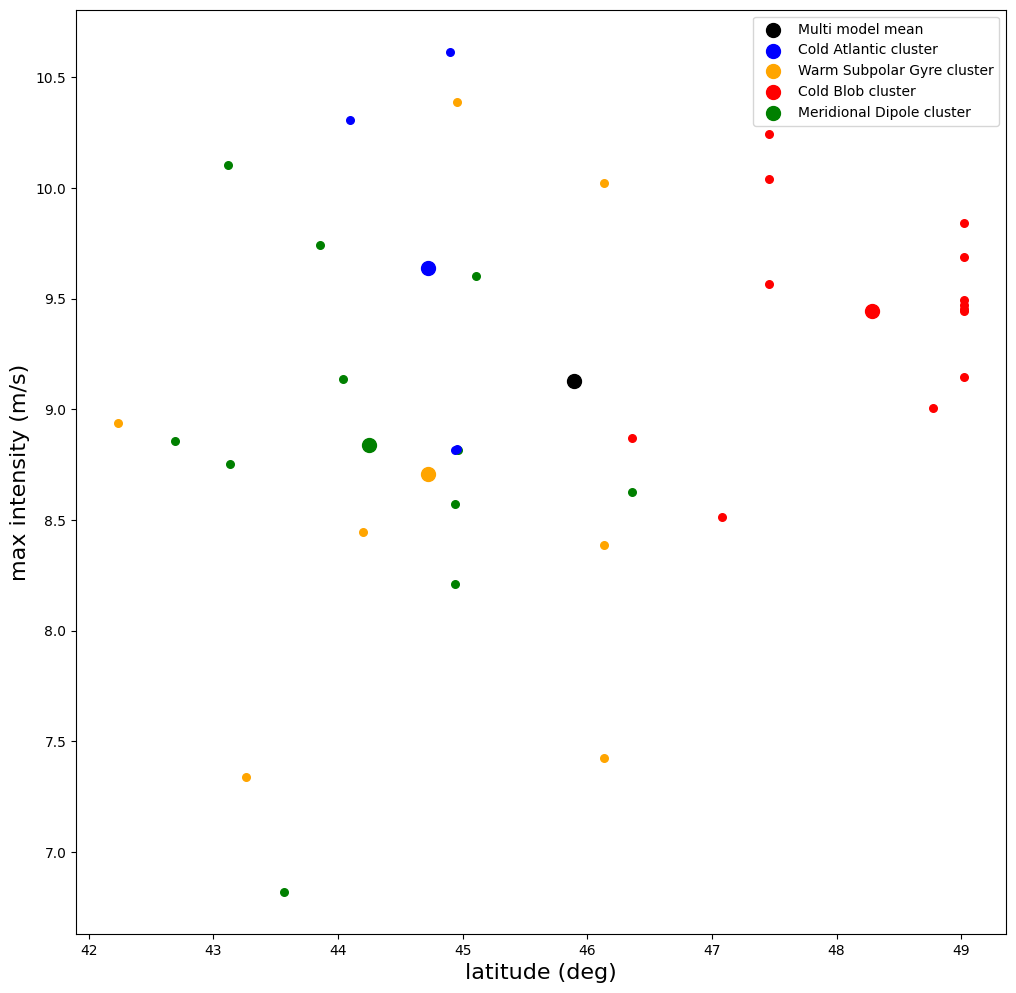

In [14]:
#Intensity-Latitude plot
fig,ax = plt.subplots(figsize=(12,12))
colour_list = ['black','blue','orange','red','green']
ax.scatter(latitude_jet_model_mean_or,intensity_jet_model_mean_or,s=100,color=colour_list[0],label='Multi model mean')
#Lista per le annotazioni
texts = []
for name in models_atmos.keys():
    for n in range(len(list_clusters)): #ciclo sui cluster
        if name in list_clusters[n]: #se un modello appartiene ad un determinato cluster
            ax.scatter(models_atmos[name]['original jet latitude'].values,models_atmos[name]['original jet intensity'].values,s=30,color=colour_list[n+1])
            #texts.append(ax.annotate(name, (models_atmos[name]['original jet latitude'].values,
            #                    models_atmos[name]['original jet intensity'].values),
            #            textcoords="offset points", xytext=(3,-1), ha='left',fontsize=5))
#Plot di ogni cluster
for n in range(len(list_clusters)):
    #ax.scatter(latitude_jet_cluster_mean_or[n],intensity_jet_cluster_mean_or[n],label=f'Cluster {n}',s=70,color=colour_list[n+1])
    ax.scatter(latitude_jet_cluster_mean_or[n],intensity_jet_cluster_mean_or[n],label=cluster_list[n],s=100,color=colour_list[n+1])
ax.legend(loc='upper right',bbox_to_anchor=(1.0, 1.0))
ax.set_xlabel('latitude (deg)',fontsize=16)
ax.set_ylabel('max intensity (m/s)',fontsize=16)
#fig.suptitle('850 hPa: Scatter plot Jet Stream intensity')

#adjust_text(texts, only_move={'points': 'xy', 'texts': 'xy'})

In [15]:
import statsmodels.api as sm

In [16]:
#Traccio la retta per la regressione lineare jet latitude - jet tilt --> linear regression con i modelli
models_jet_latitude_or = []
models_jet_tilt_or = []
for name in models_atmos.keys():
    models_jet_latitude_or.append(models_atmos[name]['original jet latitude'].values)
    models_jet_tilt_or.append(models_atmos[name]['original jet tilt'].values)
#slope, intercept = np.polyfit(models_jet_latitude,models_jet_tilt, 1)

In [17]:
# Adding a constant to the model (intercept term)
X = sm.add_constant(models_jet_latitude_or)

# Fit the OLS model
model = sm.OLS(models_jet_tilt_or, X).fit()

# Extract the slope, intercept, and p-value
slope = model.params[1]  # The coefficient for jet latitude
intercept = model.params[0]  # The intercept
p_value = model.pvalues[1]  # p-value for the slope

In [18]:
p_value

8.610758874997182e-06

Text(0, 0.5, 'tilt angle (deg)')

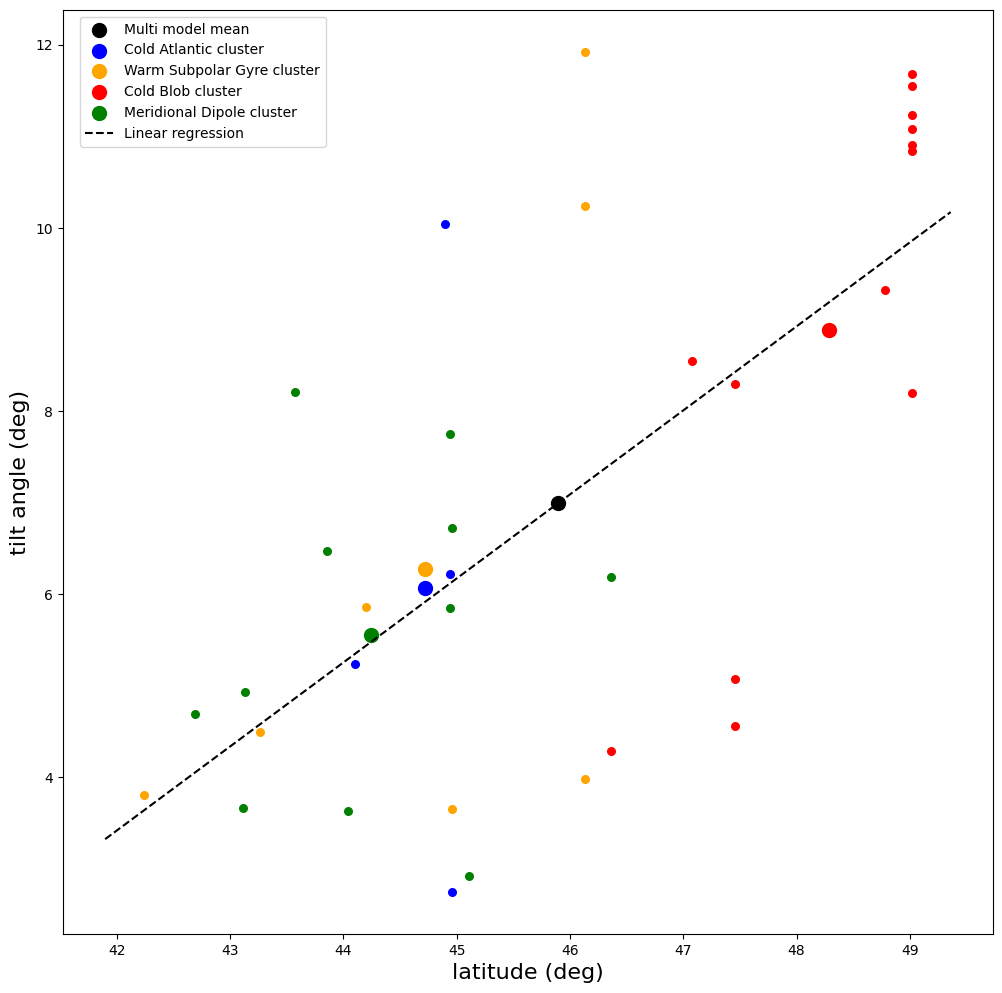

In [21]:
#Plot del jet tilt
fig,ax = plt.subplots(figsize=(12,12))
ax.scatter(latitude_jet_model_mean_or,jet_tilt_model_mean_or,s=100,color=colour_list[0],label='Multi model mean')
for name in models_atmos.keys():
    for n in range(len(list_clusters)): #ciclo sui cluster
        if name in list_clusters[n]: #se un modello appartiene ad un determinato cluster
            ax.scatter(models_atmos[name]['original jet latitude'].values,models_atmos[name]['original jet tilt'].values,s=30,color=colour_list[n+1])
            #ax.annotate(name, (models_atmos[name]['original jet latitude'].values,
            #                    models_atmos[name]['original jet tilt'].values),
            #            textcoords="offset points", xytext=(0,-10), ha='center',fontsize=5)
#Plot di ogni cluster
for n in range(len(list_clusters)):
    #ax.scatter(latitude_jet_cluster_mean_or[n],jet_tilt_cluster_mean_or[n],label=f'Cluster {n}',s=70,color=colour_list[n+1])
    ax.scatter(latitude_jet_cluster_mean_or[n],jet_tilt_cluster_mean_or[n],label=cluster_list[n],s=100,color=colour_list[n+1])

# Calcola i limiti dell'asse x per tracciare la retta di regressione
x_values = np.array(ax.get_xlim())
y_values = slope * x_values + intercept

# Aggiungi la retta di regressione al plot
ax.plot(x_values, y_values, color='black', linestyle='--', label='Linear regression')

ax.legend(loc='upper right',bbox_to_anchor=(0.29, 1.0))
ax.set_xlabel('latitude (deg)',fontsize=16)
ax.set_ylabel('tilt angle (deg)',fontsize=16)
#fig.suptitle('850 hPa: Scatter plot Jet Stream tilt')

In [20]:
with open('jet_stream_original_latitude.pkl', 'wb') as file:
    dill.dump(models_atmos, file)
    #Clusters
    dill.dump(intensity_jet_cluster_mean_or,file)
    dill.dump(latitude_jet_cluster_mean_or,file)
    dill.dump(jet_tilt_cluster_mean_or,file)
    #Model
    dill.dump(intensity_jet_model_mean_or,file)
    dill.dump(latitude_jet_model_mean_or,file)
    dill.dump(jet_tilt_model_mean_or,file)